In [1]:
#MODEL 2-----------------------------------source venv/bin/activate

In [2]:
import torch
import torch.nn as nn
from torchvision import models
from torchsummary import summary

import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
import torch.optim as optim
import matplotlib.pyplot as plt


import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# custom ResNet-50
class ResNet50Tuned(nn.Module):
    def __init__(self, num_classes=7):
        super(ResNet50Tuned, self).__init__()

        # Load original ResNet-50 without pretrained weights
        self.model = models.resnet50(pretrained=False)

        # add dropout to reduce overfitting
        self.dropout = nn.Dropout(p=0.5)

        # Match the final fully connected layer to the number of classes
        # Original: nn.Linear(2048, 1000)
        self.model.fc = nn.Sequential(
            self.dropout,                      # Dropout layer to prevent overfitting
            nn.Linear(2048, num_classes)       # New classification layer
        )

    def forward(self, x):
        return self.model(x)


# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50Tuned(num_classes=7).to(device)

# Show model summary
summary(model, input_size=(3, 224, 224))

/homes/k858p487/EndometrialCancerClassification/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/homes/k858p487/EndometrialCancerClassification/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [4]:
# Print Model Architecture
if __name__ == "__main__":
    model = ResNet50Tuned(num_classes=7)
    print(model)

ResNet50Tuned(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [5]:
#TRAIN

In [6]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Paths
train_dir = "augmented_train"               
val_csv = "val_split_BeoShock.csv"

# Hyperparameters
num_classes = 7
batch_size = 32
epochs = 50
learning_rate = 0.01
momentum = 0.9
weight_decay = 0.0001

# Image transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load training data
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Validation dataset
class ValidationDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.label_map = {label: idx for idx, label in enumerate(sorted(self.data['label'].unique()))}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['image_path']
        label = self.label_map[self.data.iloc[idx]['label']]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

val_dataset = ValidationDataset(csv_file=val_csv, transform=val_transforms)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Instantiate model
model = ResNet50Tuned(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

# Metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Early stopping
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

early_stopping = EarlyStopping(patience=5, delta=0.001)

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss, train_correct, total_train = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    scheduler.step()

    train_losses.append(train_loss / len(train_loader.dataset))
    train_accuracies.append(100 * train_correct / total_train)

    # Validation
    model.eval()
    val_loss, val_correct, total_val = 0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader.dataset))
    val_accuracies.append(100 * val_correct / total_val)

    print(f"Epoch [{epoch+1}/{epochs}] "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}% | "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

    # Early stopping check
    early_stopping(val_losses[-1])

    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

# Save model
torch.save(model.state_dict(), "model2_resnet50_tuned_trained.pth")
print("Training complete!")

/homes/k858p487/EndometrialCancerClassification/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/homes/k858p487/EndometrialCancerClassification/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/50] Train Loss: 2.4655, Train Acc: 27.09% | Val Loss: 1.9489, Val Acc: 21.17%
Epoch [2/50] Train Loss: 1.7933, Train Acc: 31.51% | Val Loss: 1.7338, Val Acc: 27.02%
Epoch [4/50] Train Loss: 1.5285, Train Acc: 39.39% | Val Loss: 1.5423, Val Acc: 37.30%
Epoch [5/50] Train Loss: 1.4337, Train Acc: 43.65% | Val Loss: 1.4298, Val Acc: 44.15%
Epoch [6/50] Train Loss: 1.2800, Train Acc: 50.28% | Val Loss: 1.2312, Val Acc: 52.02%
Epoch [7/50] Train Loss: 1.0770, Train Acc: 58.10% | Val Loss: 1.0343, Val Acc: 59.07%
Epoch [8/50] Train Loss: 0.9441, Train Acc: 63.65% | Val Loss: 1.3593, Val Acc: 54.23%
Epoch [9/50] Train Loss: 0.7705, Train Acc: 70.66% | Val Loss: 1.0511, Val Acc: 63.71%
Epoch [10/50] Train Loss: 0.6553, Train Acc: 75.01% | Val Loss: 1.0473, Val Acc: 63.31%
Epoch [11/50] Train Loss: 0.5380, Train Acc: 79.75% | Val Loss: 0.9566, Val Acc: 68.95%
Epoch [12/50] Train Loss: 0.4410, Train Acc: 83.49% | Val Loss: 1.2997, Val Acc: 62.10%
Epoch [13/50] Train Loss: 0.3522, Train 

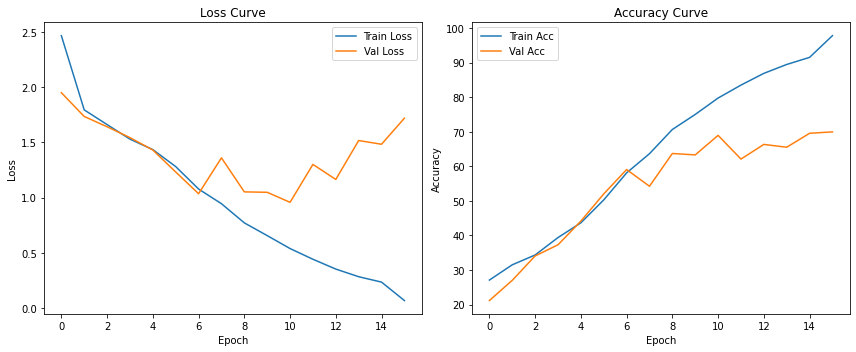

In [7]:
# Plot curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#Original Hyperparameter ResNet 50 for Training ImageNet-----------

#Optimizer	SGD (Stochastic Gradient Descent)
#Learning Rate	0.1 (reduced by 10x at specific epochs)
#Momentum	0.9
#Weight Decay	1e-4 (to regularize and prevent overfitting)
#Batch Size	256 (distributed across multiple GPUs)
#Number of Epochs	90
#Learning Rate Scheduler	Step decay (every 30 epochs)
#Initialization	He initialization
#Input Image Size	224×224

In [8]:
#Testing

             Metric     Value
0  Top-1 Error Rate  0.354839
1  Top-3 Error Rate  0.056452
2  Top-5 Error Rate  0.004032
3          Accuracy  0.645161
4          F1 Score  0.641750
5         AUC Score  0.844206


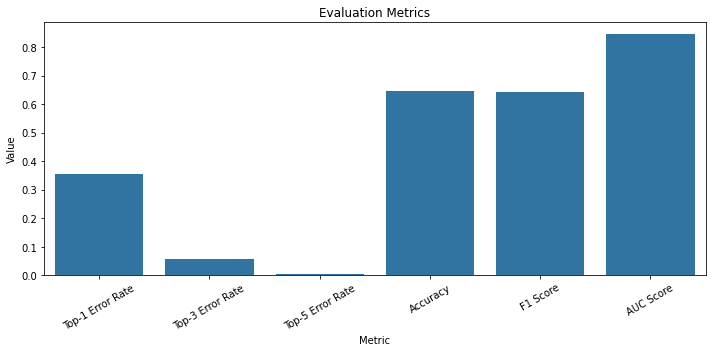

In [10]:
# Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
csv_file = 'test_split_BeoShock.csv'
num_classes = 7
batch_size = 32

# Define label mapping for AUC score
non_cancerous = ['NE_Follicular', 'NE_Luteal', 'NE_Menstrual']
cancerous = ['EA', 'EP', 'EH_Simple', 'EH_Complex']
all_labels = cancerous + non_cancerous
label_to_idx = {label: idx for idx, label in enumerate(sorted(all_labels))}
binary_map = {label_to_idx[lbl]: 0 if lbl in non_cancerous else 1 for lbl in all_labels}

# Image transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Transform Test Dataset
class TestDataset(Dataset):
    def __init__(self, csv_file, transform):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.label_map = label_to_idx

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx]['image_path']
        label = self.label_map[self.data.iloc[idx]['label']]
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.data)

# Load model
model = ResNet50Tuned(num_classes=num_classes).to(device)
model.load_state_dict(torch.load('model2_resnet50_tuned_trained.pth', map_location=device))
model.eval()

# Load data
dataset = TestDataset(csv_file, transform)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Inference
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in loader:
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1).cpu().numpy()
        all_probs.append(probs)
        all_labels.extend(labels.numpy())

all_probs = np.concatenate(all_probs)
all_labels = np.array(all_labels)

# Metrics
top1_preds = np.argmax(all_probs, axis=1)
top1_error = 1 - np.mean(top1_preds == all_labels)

top3_preds = np.argsort(all_probs, axis=1)[:, -3:]
top3_error = 1 - np.mean([label in top3 for label, top3 in zip(all_labels, top3_preds)])

top5_preds = np.argsort(all_probs, axis=1)[:, -5:]
top5_error = 1 - np.mean([label in top5 for label, top5 in zip(all_labels, top5_preds)])

accuracy = accuracy_score(all_labels, top1_preds)

f1 = f1_score(all_labels, top1_preds, average='weighted')

# Binary labels for AUC
binary_labels = np.array([binary_map[lbl] for lbl in all_labels])
cancer_indices = [label_to_idx[lbl] for lbl in cancerous]
binary_probs = all_probs[:, cancer_indices].sum(axis=1)
auc = roc_auc_score(binary_labels, binary_probs)

# Results
metrics = {
    "Top-1 Error Rate": top1_error,
    "Top-3 Error Rate": top3_error,
    "Top-5 Error Rate": top5_error,
    "Accuracy": accuracy,
    "F1 Score": f1,
    "AUC Score": auc
}

# Plot
df = pd.DataFrame(metrics.items(), columns=["Metric", "Value"])
print(df)

plt.figure(figsize=(10, 5))
sns.barplot(data=df, x="Metric", y="Value")
plt.xticks(rotation=30)
plt.title("Evaluation Metrics")
plt.tight_layout()
plt.show()